# Maximum Entropy Policy Gradients 

For my first post, I will set up a simple implimentation of maximum entropy policy gradients applied to simple 
grid world problem. Max entropy policy gradients is implemented in a similar manner to vanilla policy gradients,
but includes an added entropy term within the advantage term. For more information see "reinforcement learning and control as probabalistic inference" to see more. 

In [21]:
import torch
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

## First we want to make  a make a policy
After including our imports we will need to create a policy class to sample new actions, and to compute the 
log probabilities of each of the actions under our current model. I our case, since we will be working with a 
grid world, we will allow 5 actions for up, down, left, right, and stationary. In order to pick one of these 
actions, we will sample from a discrete distribution parameterized by a linear function based on the size of the 
input and the number of actions, and then pass the outputs through a softmax layer. In order to calculate the 
probability of an action, we simply look up the index of the action output by the softmax layer. We also add a little 
bit of noise to the probability to ensure its never exactly zero.

In [22]:
class POLICY(torch.nn.Module):
    """
    POLICY CLASS: CONTAINS ALL USABLE FUNCTIONAL FORMS FOR THE AGENTS POLICY, ALONG WITH
    THE CORROSPONDING HELPER FUNCTIONS
    """
    def __init__(self, state_size, action_size):
        super(POLICY, self).__init__()
        # initializations
        self.state_size = state_size
        self.action_size = action_size
        self.linear = torch.nn.Linear(state_size, action_size)
        self.softmax = torch.nn.Softmax()
        self.discrete = lambda prob: Categorical(torch.tensor(prob))

    def sample_action(self, state, randomness):
        # Here the forward pass is simply a linear function
        probabilities = self.linear(torch.FloatTensor(state))
        probabilities = self.softmax(probabilities)
        action = torch.distributions.Categorical(probabilities)
        
        # Now check whether we will pick a random action
        if torch.distributions.uniform.Uniform(0,1).sample() < randomness:
            return torch.randint(0, 5, (1,))
        else:
            return action.sample()

    def logprob_action(self, state, action):
        probabilities = self.linear(state)
        probabilities = self.softmax(probabilities)
        log_prob = min(0, torch.log(probabilities[action.long()]+0.0001))
        return log_prob


## Next we need to make the grid world the agent will sample from
next we need to actually make the simulator thatour agent will be using. The only two functions we will need for
this, one to step the agent, and one to create a full simulations. There are five moves that are possible, and we 
include the abiliity to average over several trajectories.

In [23]:
class GRID_WORLD():
    """
    GRID WORLD CLASS: HELPER CLASS TO INSTANTIATE A SMALL MDP PROBLEM TO TEST POLICY GRADIENT
    METHODS ON TO ENSURE CORRECTNESS, ALSO ALOWS FOR FOR TESTING OF NEW TYPES OF ENVIROMENTS
    WITH DIFFERENT STATESPACE DISTRIBUTIONS ECT.
    """

    def __init__(self, pre_determined_grid, start_state):
        super(GRID_WORLD, self).__init__()
        self.grid = pre_determined_grid
        self.start_state = start_state
        self.grid_dim = [len(pre_determined_grid),len(pre_determined_grid[0])]

    def step_agent(self, state, action):
        #[row, column]
        if action == 1: # down
            # if we are in top row no change
            if state[0] == 0:
                None
            # otherwise increase row position
            else:
                state[0] -= 1
        elif action == 2: # up
            if state[0] == self.grid_dim[1]-1:
                None
            # otherwise increase row position
            else:
                state[0] += 1
        elif action == 3: # right
            if state[1] == self.grid_dim[0]-1:
                None
            # otherwise increase row position
            else:
                state[1] += 1
        elif action == 4: # down
            if state[1] == 0:
                None
            # otherwise increase row position
            else:
                state[1] -= 1
        elif action == 0: # dont_move
            None
        else:
            print("key error for movement in step_agent")
        return state

    def simulate_trajectory(self, T, samples, policy):
        # initialize variables to iterate
        current_state =  deepcopy(self.start_state)
        current_reward = deepcopy(self.grid[current_state[0]][current_state[1]])
        current_action = policy(current_state)
        # initialize tensor storage
        state_tensor = torch.zeros((len(current_state), T, samples), requires_grad = False)
        reward_tensor = torch.zeros((T, samples), requires_grad = False)
        action_tensor = torch.zeros((T, samples), requires_grad = False)
        # iterate through all states and actions
        for sample in range(samples):
            for t in range(T):
                # store values
                state_tensor[:,t,sample] = torch.FloatTensor(current_state)
                reward_tensor[t,sample] = current_reward
                action_tensor[t,sample] = current_action
                # simulate new values
                current_state = self.step_agent(current_state, current_action)
                current_reward = deepcopy(self.grid[current_state[0]][current_state[1]])
                current_action = policy(current_state)

        # return it all
        return state_tensor, action_tensor, reward_tensor

## Now the Cost Function

This cost function will include the primary forward call that is used when we apply pytorches backward function, 
a def to compute the advantage estimate, and finally a baseline function. In this case we could apply a clipped 
exponential average, however this can easily be replaced by a optimization procedure that directly minimizes the 
MSE between the estimated baseline (which is now parameterized), and the cumulative reward (regularized by the entropy). I tried to vectorize as much of the computation as possible without making it unreadable. For now we will 
just leave the baseline at zero, to see if we can stabalize the gradient by increasing sampling.

In [24]:
class POLICY_GRADIENT_LOSS(torch.nn.Module):
    """ MAXIMUM ENTROPY POLICY GRADIENTS LOSS FUNCTION """
    def __init__(self, alpha, discount, sd, trajectory_length, simulations):
        super(POLICY_GRADIENT_LOSS, self).__init__()
        self.sd = sd
        self.alpha = alpha
        self.discount = discount
        self.trajectory_length = trajectory_length
        self.simulations = simulations
        self.base_line = 0

    def Baseline_approximation(self, x, y, state_size):
        baseline = 0
        return baseline

    def Advantage_estimator(self, logliklihood_tensor, trajectories_state_tensor, \
                            trajectories_action_tensor, trajectories_reward_tensor):
        """ COMPUTES ROLL OUT WITH MAX ENT REGULARIZATION """
        # initialize cumulative running average for states ahead
        cumulative_rollout = torch.zeros([self.trajectory_length, self.simulations])
        # calculate cumulative running average for states ahead + subtract entropy term
        cumulative_rollout[self.trajectory_length-1,:] = trajectories_reward_tensor[self.trajectory_length-1,:] \
                                                         + self.alpha*logliklihood_tensor[self.trajectory_length-1,:]
        # primary loop
        for time in reversed(range(0, self.trajectory_length-1)):
            cumulative_rollout[time,:] = trajectories_reward_tensor[time, :] \
                                         + self.discount * cumulative_rollout[time+1,:] \
                                         + self.alpha * logliklihood_tensor[time,:]
        # detach cumulative reward from computation graph
        advantage = cumulative_rollout.detach()
        return advantage

    def forward(self, model_liklihood, trajectories_state_tensor, trajectories_action_tensor, trajectories_reward_tensor):
        """ CALCULATE LOG LIKLIHOOD OF TRAJECTORIES """
        # initialize tensor for log liklihood stuff
        logliklihood_tensor = torch.zeros([self.trajectory_length, self.simulations])
        # generate tensor for log liklihood stuff
        for time in range(self.trajectory_length):
            for simulation in range(self.simulations):
                # [simulation #, value, time step]
                logliklihood_tensor[time,simulation] = model_liklihood(trajectories_state_tensor[:,time,simulation],\
                                                                       trajectories_action_tensor[time,simulation])
        """ CALCULATE ADVANTAGE REGULARIZED BY ENTROPY """
        A_hat = self.Advantage_estimator(logliklihood_tensor, trajectories_state_tensor, trajectories_action_tensor, \
                                         trajectories_reward_tensor)
        """ CALCULATE POLICY GRADIENT OBJECTIVE """
        # initialize expectation tensor
        expectation = 0
        # calculate instance of expectation for timestep then calc sample mean
        for time in range(self.trajectory_length):
            expectation += torch.dot(A_hat[time,:], logliklihood_tensor[time,:])/self.simulations
        # sum accross time
        expectation = -1 * torch.sum(expectation)/self.trajectory_length

        """ RETURN """
        return expectation


## Lastly the Training Function

In this function we generate the policy class, initialize the optimizer and loss functions, and then take optimization 
steps. In order to do this we have to sample a set of trajectories under our current policy, and then compute the entropy regularized cumulative reward at each step. While I have chosen to use Adam, it has been shown that convergence can be sped up by using conjugate gradient decent instead of adams diagnol approximation. In order to do this we would simply average the sum of the outer product of each of our score functions to approximate the fisher information, and then apply a forward solve between this matrix and the gradient vector generated from backprop.

In [25]:
def train_policy(epochs, grid, samples, T, discount, alpha, sd):

    # initialize policy
    policy_obj = POLICY(2, 5)

    # set optimization info
    optimizer = torch.optim.Adam(policy_obj.parameters(), lr=1e-2)
    loss_func = POLICY_GRADIENT_LOSS(alpha, discount, sd,  T, samples)
    
    # plotting storage (loss and cumulative reward)
    loss_per_iteration = torch.zeros((epochs))
    cr_per_iteration = torch.zeros((epochs))
    
    # train model
    for epoch in range(epochs):
        
        # set the probability of picking a random move
        randomness = (10 + epoch)/(1+epoch)**2
        
        # set policy
        policy = lambda state: policy_obj.sample_action(state, randomness)
        log_prob = lambda state, action: policy_obj.logprob_action(state, action)
        
        # get sampled trajectories
        state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
        
        # loss objective being minimized
        loss = loss_func(log_prob, state_tensor, action_tensor, reward_tensor)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backprop through computation graph
        loss.backward()
        
        # step optimizer
        optimizer.step()
        
        # print loss
        print("current loss at iteration: " + str(epoch/epochs) + ", with loss: " + str(loss) + ", ends in state: " + str(state_tensor[:,-1,0]), end='\r')
        
        # store loss
        loss_per_iteration[epoch] = loss
        cr_per_iteration[epoch] = sum(sum(reward_tensor))/samples
        
    # print a trajectory
    state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
    for time in range(50):
        print(state_tensor[:,time,0], reward_tensor[time,0], action_tensor[time,0], end='\r')

    # return policy
    return policy, loss_per_iteration, cr_per_iteration

# Now all we have to do is run it!
Below I have set the grid that we will be using, as well as the start state and the number of iterations.  

In [45]:
pre_determined_grid = [[-1,   -1,  -1,   -10,   -1, 10**3],
                       [-100, -1,  -10,  -1,   -10, -10],
                       [-1,   -10, -100, -10,  -1, -1],
                       [-1,   -1,  -100, -10,  -1, -1],
                       [-10,  -1,  -100, -100, -100, -1],
                       [-1,   -1,  -100, -100, -100, -1]]

# hyper parameters
iterations = 500
Time = 300
simulations = 10
discount = 0.99

#initializations
start_state = [5,0]
policy_obj = POLICY(2, 5)
policy = lambda state: policy_obj.sample(state)
grid = GRID_WORLD(pre_determined_grid, start_state)
policy, loss_per_iteration, cr_per_iteration = train_policy(iterations, grid, 10, Time, discount, 1, 1)


## Now lets plot everything 

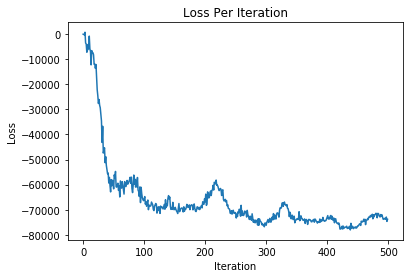

In [47]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(iterations)], -1*loss_per_iteration.detach().numpy())
plt.title('Loss Per Iteration')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

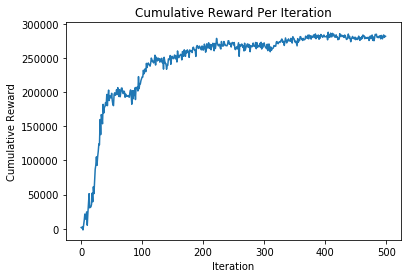

In [48]:
plt.plot([i for i in range(iterations)], cr_per_iteration.numpy())
plt.title('Cumulative Reward Per Iteration')
plt.ylabel('Cumulative Reward')
plt.xlabel('Iteration')
plt.show()

## It looks like everything has converged, but lets look a trajectory to see if we are actually close

In [49]:
T = 50
samples = 1
state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
for time in range(25):
    print(state_tensor[:,time,0], reward_tensor[time,0], action_tensor[time,0])

tensor([5., 0.]) tensor(-1.) tensor(1.)
tensor([4., 0.]) tensor(-10.) tensor(1.)
tensor([3., 0.]) tensor(-1.) tensor(1.)
tensor([2., 0.]) tensor(-1.) tensor(1.)
tensor([1., 0.]) tensor(-100.) tensor(1.)
tensor([0., 0.]) tensor(-1.) tensor(2.)
tensor([1., 0.]) tensor(-100.) tensor(3.)
tensor([1., 1.]) tensor(-1.) tensor(1.)
tensor([0., 1.]) tensor(-1.) tensor(1.)
tensor([0., 1.]) tensor(-1.) tensor(3.)
tensor([0., 2.]) tensor(-1.) tensor(3.)
tensor([0., 3.]) tensor(-10.) tensor(1.)
tensor([0., 3.]) tensor(-10.) tensor(1.)
tensor([0., 3.]) tensor(-10.) tensor(3.)
tensor([0., 4.]) tensor(-1.) tensor(1.)
tensor([0., 4.]) tensor(-1.) tensor(1.)
tensor([0., 4.]) tensor(-1.) tensor(3.)
tensor([0., 5.]) tensor(1000.) tensor(0.)
tensor([0., 5.]) tensor(1000.) tensor(1.)
tensor([0., 5.]) tensor(1000.) tensor(3.)
tensor([0., 5.]) tensor(1000.) tensor(1.)
tensor([0., 5.]) tensor(1000.) tensor(3.)
tensor([0., 5.]) tensor(1000.) tensor(1.)
tensor([0., 5.]) tensor(1000.) tensor(3.)
tensor([0., 5.]) t

## We can also look at what actions are sampled at all positions to see if they seem reasonable

In [50]:
for x in range(len(pre_determined_grid[0])):
    row = []
    for y in range(len(pre_determined_grid)):
        row.append(int(policy([x, y])))
    print(row)

[0, 0, 2, 3, 3, 0]
[1, 0, 3, 4, 1, 3]
[3, 0, 1, 1, 1, 0]
[1, 1, 0, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]


## Thats it for my first blog post!
Alright, thats about it! we have a functioning implimentation of maximum entropy policy gradients. Next time we will look at different baseline functions (also called critics) to reduce variance of our score function (the log probability of a action given a state). One thing to note here, is that I did have to fiddle with the reward at the target position to ensure that the agent actually converged to the correct position. In fact for whatever reason, in some cases, even after the addition of some additional noise near the begining of training, the agent settled into not 
doing anything. Which is one of the largest issues with maximum entropy RL, that the ratio of the reward surface and entropy surface matter, and inequity between them can mean bad solutions. Feel free to leave comments or suggestions below to make this code a bit quicker (or if you see any errors). Happy holidays, and Praise the Sun!